In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [3]:
import numpy as np
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Define the percentage of samples to remove from each class
remove_percentages = [0.3, 0.2, 0.6, 0.4, 0.7, 0.1, 0.5, 0.6, 0.2, 0.8]

def remove_samples(x, y, remove_percentages):
    for class_label, remove_percentage in enumerate(remove_percentages):
        # Find indices of samples belonging to the current class
        class_indices = np.where(y == class_label)[0]
        # Determine the number of samples to keep
        num_samples_to_keep = int(len(class_indices) * (1 - remove_percentage))
        # Randomly shuffle class indices
        np.random.shuffle(class_indices)
        # Keep the first num_samples_to_keep samples and remove the rest
        samples_to_remove_indices = class_indices[num_samples_to_keep:]
        # Remove selected samples from both features and labels
        x = np.delete(x, samples_to_remove_indices, axis=0)
        y = np.delete(y, samples_to_remove_indices, axis=0)
    return x, y

# Modify the training set
x_train, y_train = remove_samples(x_train, y_train, remove_percentages)

# Modify the testing set
x_test, y_test = remove_samples(x_test, y_test, remove_percentages)

# Print the shapes of the modified datasets
print("Modified Training Set Shape:", x_train.shape, y_train.shape)
print("Modified Testing Set Shape:", x_test.shape, y_test.shape)


170498071/170498071 [==============================] - 3s 0us/step
Modified Training Set Shape: (27999, 32, 32, 3) (27999, 1)
Modified Testing Set Shape: (5599, 32, 32, 3) (5599, 1)


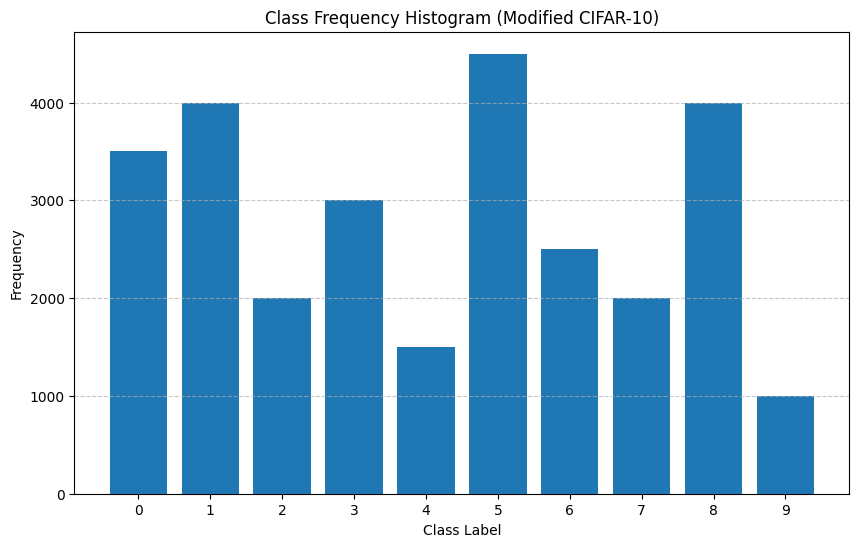

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the frequency of each class label
class_counts = np.bincount(y_train.flatten())

# Plot a histogram of class frequencies
plt.figure(figsize=(10, 6))
plt.bar(range(10), class_counts)
plt.title('Class Frequency Histogram (Modified CIFAR-10)')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(range(10))  # Label x-axis with class labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [5]:
img_rows, img_cols , channels= 32,32,3

#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (27999, 32, 32, 3)
27999 train samples
5599 test samples


In [6]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [7]:
import keras as k

from keras.utils import to_categorical

# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)


In [8]:
y_train.shape

(27999, 10)

In [9]:

#the model has 6 convolutional layers, 1 flatten layer, and 2 dense layers, making it a total of 9 layers.
# Smaller than Vgg-16

reg=None
num_filters=32
ac='relu'
adm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08) # Removed the 'decay' argument
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [11]:
pip install modAL-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 5.0 MB/s eta 0:00:00


# Least Confidence

In [14]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)

# Initialize the ActiveLearner
learner = ActiveLearner(
    estimator=model,
    X_training=x_labeled,
    y_training=y_labeled,
    query_strategy=uncertainty_sampling
)

n_queries = 10

n_samples_per_iteration = 2000


# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)

    queried_labels = y_unlabeled[query_idx]


    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)



    # Update the learner with the newly labeled data
    learner.teach(query_sample, queried_labels)

    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')


    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')


     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')



    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')

    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

832/832 [==============================] - 5s 6ms/step
X_labeled  (3399, 32, 32, 3)
y_labeled  (3399, 10)
learner x_train  (1399, 32, 32, 3)
learner y_train  (1399, 10)
175/175 [==============================] - 1s 4ms/step
Iteration 1 - Train Accuracy: 0.9356, Train Precision: 0.9238, Train Recall: 0.9404, Train F1: 0.9295
Iteration 1 - Test Accuracy: 0.7466, Test Precision: 0.7364, Test Recall: 0.7315, Test F1: 0.7264
Iteration 1 - Labeled Accuracy: 0.9712, Labeled Precision: 0.9704, Labeled Recall: 0.9648, Labeled F1: 0.9671
Iteration 1 - unlabeled Accuracy: 0.9307, unlabeled Precision: 0.9158, unlabeled Recall: 0.9374, unlabeled F1: 0.9236
769/769 [==============================] - 2s 3ms/step
X_labeled  (5399, 32, 32, 3)
y_labeled  (5399, 10)
learner x_train  (3399, 32, 32, 3)
learner y_train  (3399, 10)
175/175 [==============================] - 1s 5ms/step
Iteration 2 - Train Accuracy: 0.9554, Train Precision: 0.9538, Train Recall: 0.9488, Train F1: 0.9504
Iteration 2 - Test Acc

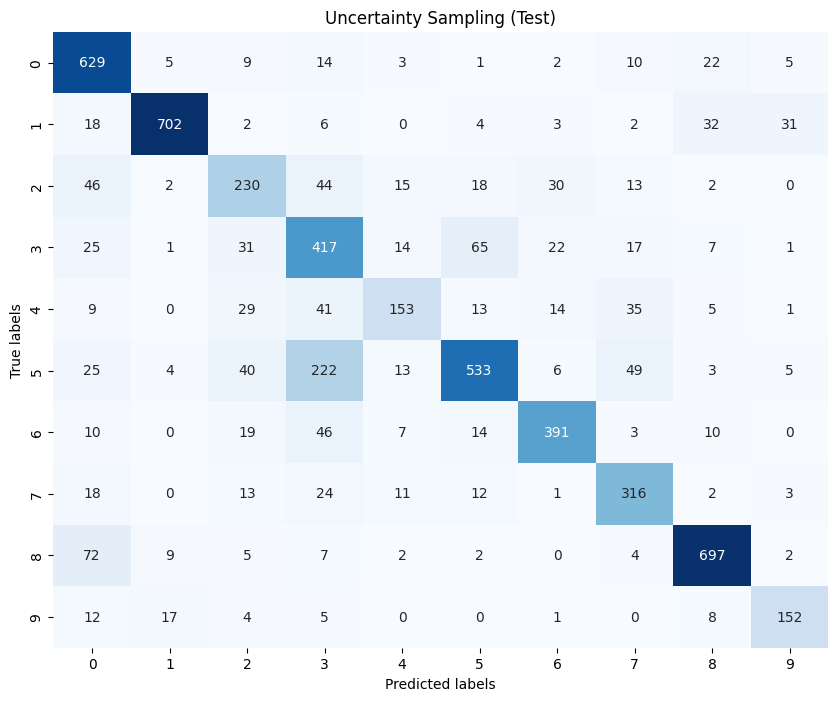

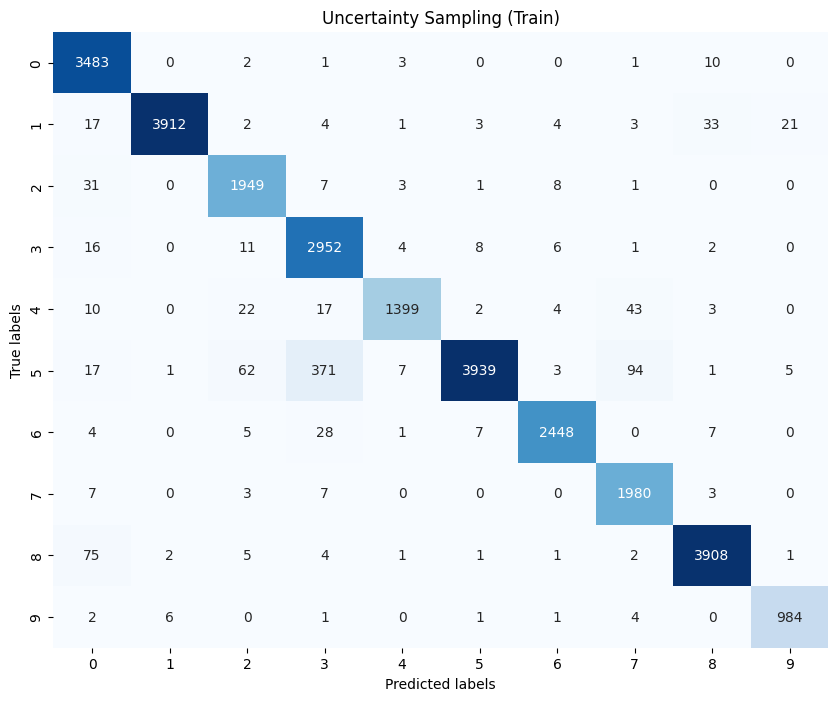

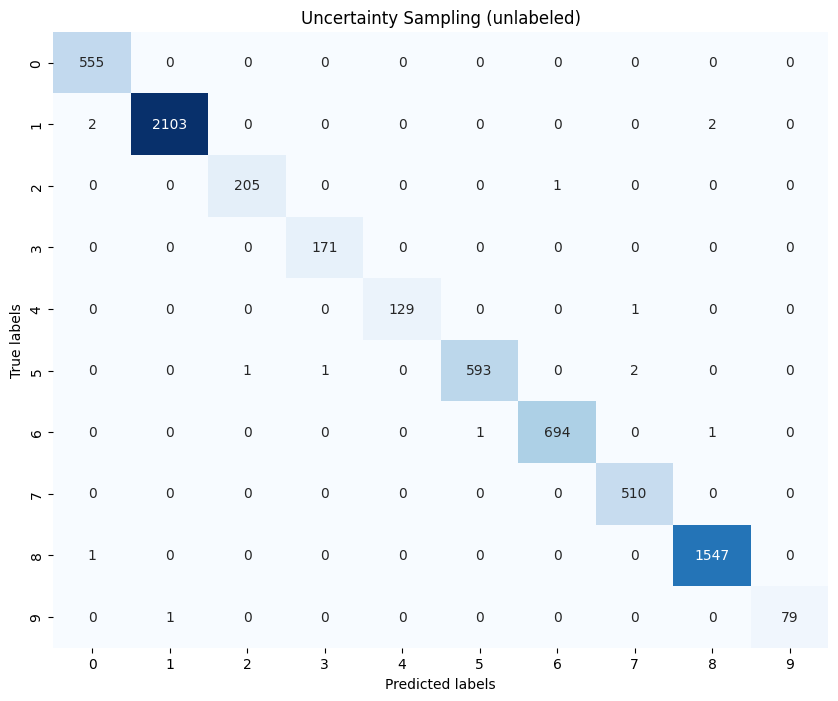

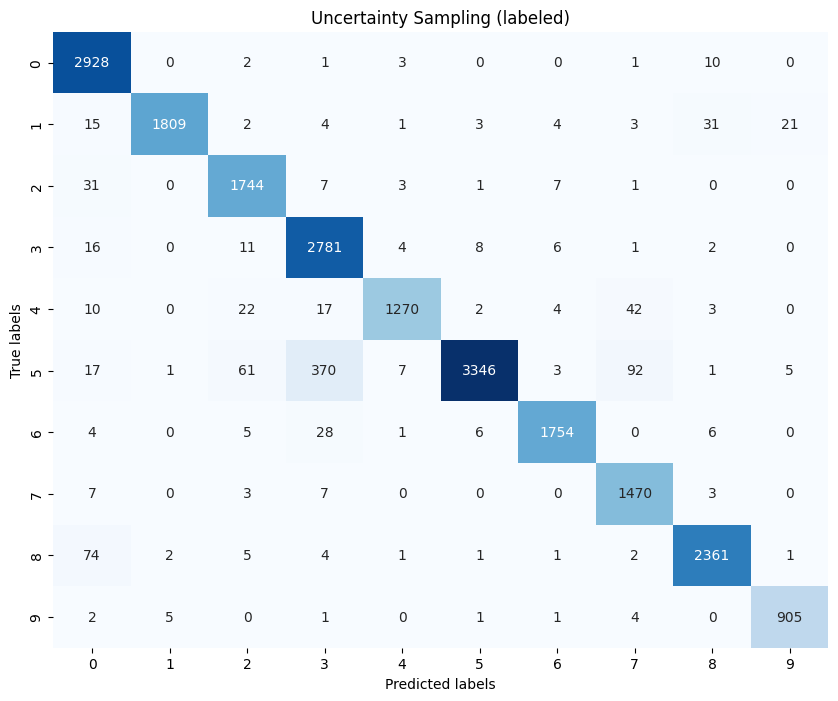

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Uncertainty Sampling (labeled)')
plt.show()




In [16]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.73      0.90      0.80       700
           1       0.95      0.88      0.91       800
           2       0.60      0.57      0.59       400
           3       0.50      0.69      0.58       600
           4       0.70      0.51      0.59       300
           5       0.81      0.59      0.68       900
           6       0.83      0.78      0.81       500
           7       0.70      0.79      0.74       400
           8       0.88      0.87      0.88       800
           9       0.76      0.76      0.76       199

    accuracy                           0.75      5599
   macro avg       0.75      0.74      0.74      5599
weighted avg       0.77      0.75      0.75      5599

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3500
           1       1.00      0.98      0.99      4000
           2       0.95      0.97      0.96      2000
           3       0.87 

# Random Sampling

In [20]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


def random_sampling(classifier, X_pool,n_instances):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
    return query_idx, X_pool[query_idx]


learner = ActiveLearner(
    estimator=model,
    X_training=x_labeled,
    y_training=y_labeled,
    query_strategy=random_sampling
)

n_queries = 10

n_samples_per_iteration = 2000

# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)

    queried_labels = y_unlabeled[query_idx]

    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)



    learner.teach(query_sample, queried_labels)

    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')


    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')


     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')




    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')

    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

44/44 [==============================] - 1s 17ms/step - loss: 1.4954 - accuracy: 0.5104
X_labeled  (3399, 32, 32, 3)
y_labeled  (3399, 10)
learner x_train  (1399, 32, 32, 3)
learner y_train  (1399, 10)
175/175 [==============================] - 1s 5ms/step
Iteration 1 - Train Accuracy: 0.4713, Train Precision: 0.5594, Train Recall: 0.3883, Train F1: 0.3840
Iteration 1 - Test Accuracy: 0.4528, Test Precision: 0.5683, Test Recall: 0.3722, Test F1: 0.3702
Iteration 1 - Labeled Accuracy: 0.5357, Labeled Precision: 0.6425, Labeled Recall: 0.4539, Labeled F1: 0.4556
Iteration 1 - unlabeled Accuracy: 0.4624, unlabeled Precision: 0.5443, unlabeled Recall: 0.3792, unlabeled F1: 0.3740
X_labeled  (5399, 32, 32, 3)
y_labeled  (5399, 10)
learner x_train  (3399, 32, 32, 3)
learner y_train  (3399, 10)
175/175 [==============================] - 1s 3ms/step
Iteration 2 - Train Accuracy: 0.5759, Train Precision: 0.5816, Train Recall: 0.4982, Train F1: 0.5113
Iteration 2 - Test Accuracy: 0.5471, Test Pr

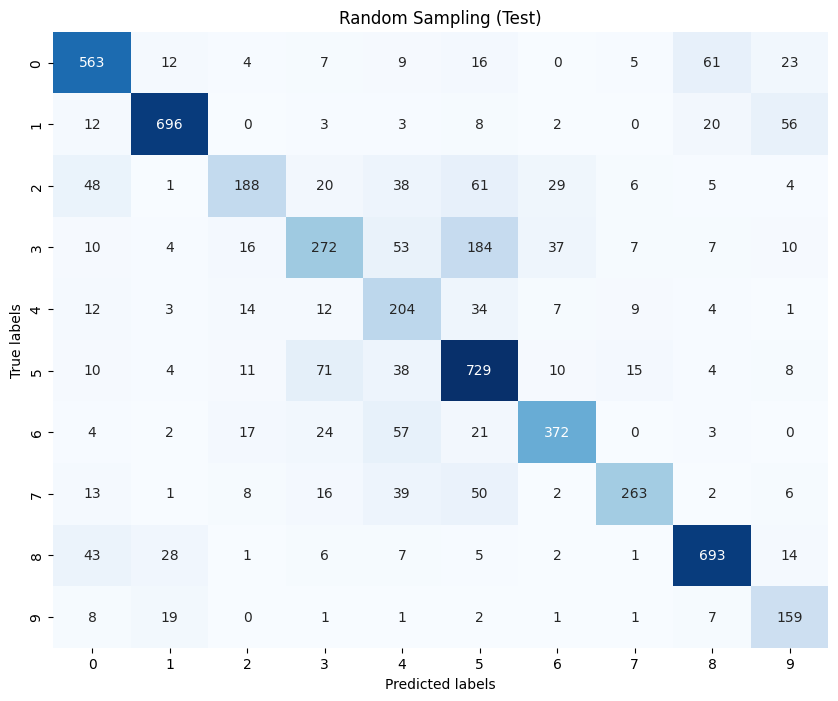

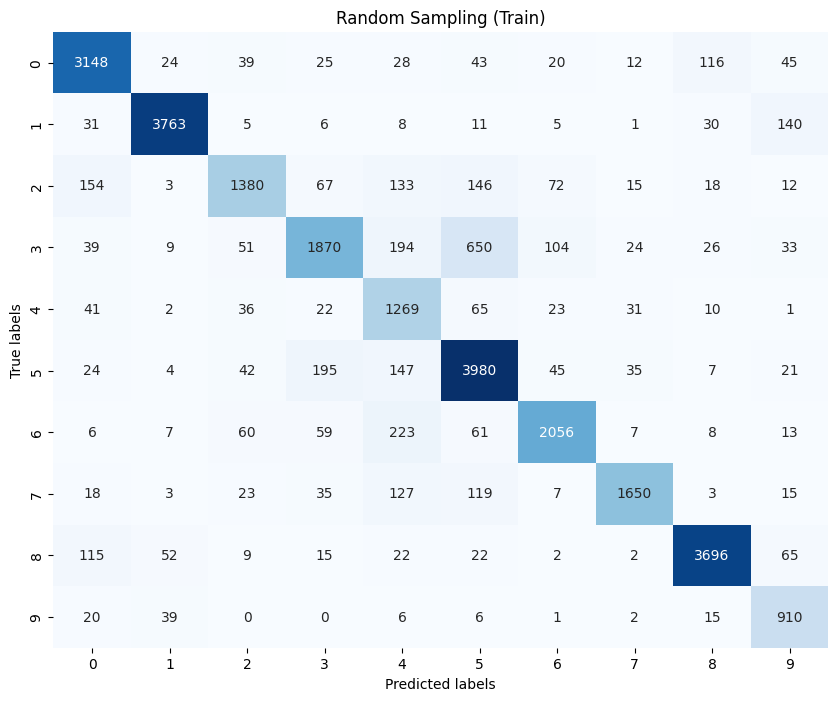

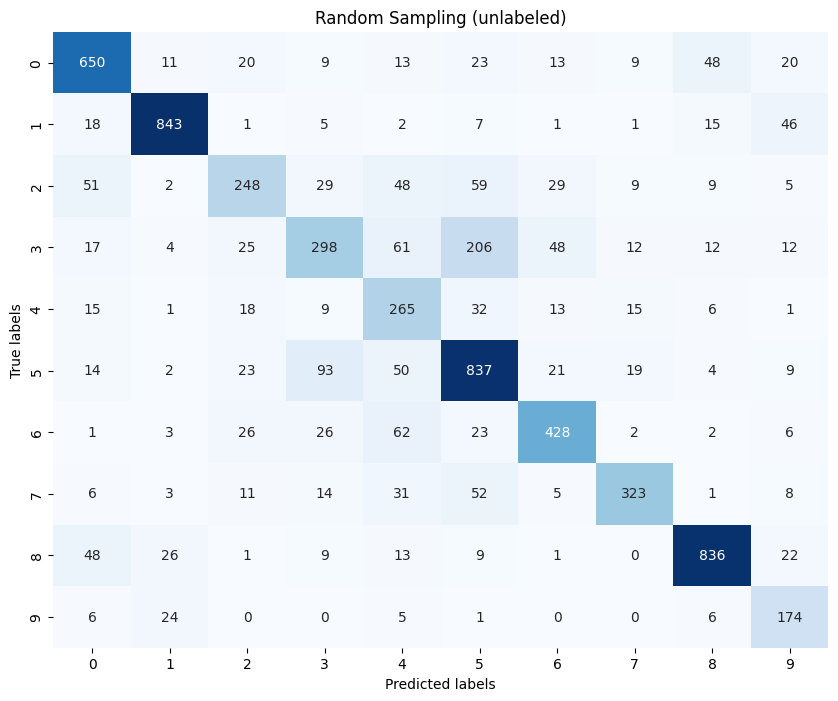

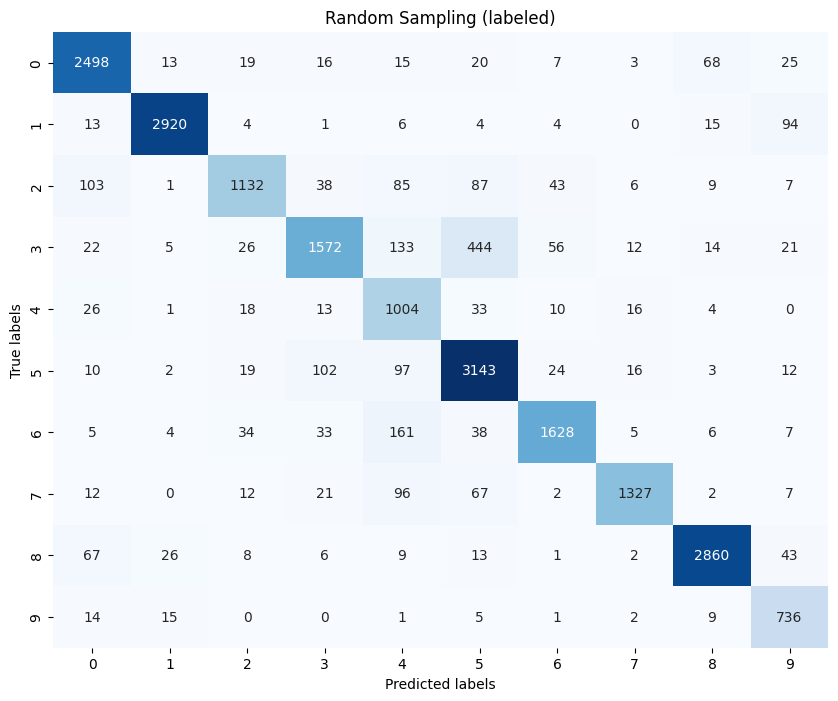

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Sampling (labeled)')
plt.show()




In [22]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.78      0.80      0.79       700
           1       0.90      0.87      0.89       800
           2       0.73      0.47      0.57       400
           3       0.63      0.45      0.53       600
           4       0.45      0.68      0.54       300
           5       0.66      0.81      0.73       900
           6       0.81      0.74      0.77       500
           7       0.86      0.66      0.74       400
           8       0.86      0.87      0.86       800
           9       0.57      0.80      0.66       199

    accuracy                           0.74      5599
   macro avg       0.72      0.72      0.71      5599
weighted avg       0.75      0.74      0.74      5599

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      3500
           1       0.96      0.94      0.95      4000
           2       0.84      0.69      0.76      2000
           3       0.82 

# Margin Sampling

In [25]:
from modAL.models import ActiveLearner
from modAL.uncertainty import margin_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)

learner = ActiveLearner(
    estimator=model,
    X_training=x_labeled,
    y_training=y_labeled,
    query_strategy=margin_sampling
)

n_queries = 10

n_samples_per_iteration = 2000


# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)

    queried_labels = y_unlabeled[query_idx]

    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)



    learner.teach(query_sample, queried_labels)

    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')


    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')


     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')



    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')

    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

832/832 [==============================] - 4s 4ms/step
X_labeled  (3399, 32, 32, 3)
y_labeled  (3399, 10)
learner x_train  (1399, 32, 32, 3)
learner y_train  (1399, 10)
875/875 [==============================] - 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1/107 [..............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107/107 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175/175 [==============================] - 0s 3ms/step
Iteration 1 - Train Accuracy: 0.1431, Train Precision: 0.0439, Train Recall: 0.1003, Train F1: 0.0256
Iteration 1 - Test Accuracy: 0.1431, Test Precision: 0.0393, Test Recall: 0.1002, Test F1: 0.0254
Iteration 1 - Labeled Accuracy: 0.1118, Labeled Precision: 0.0445, Labeled Recall: 0.1002, Labeled F1: 0.0206
Iteration 1 - unlabeled Accuracy: 0.1475, unlabeled Precision: 0.0439, unlabeled Recall: 0.1003, unlabeled F1: 0.0262


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


769/769 [==============================] - 2s 3ms/step
X_labeled  (5399, 32, 32, 3)
y_labeled  (5399, 10)
learner x_train  (3399, 32, 32, 3)
learner y_train  (3399, 10)
175/175 [==============================] - 0s 3ms/step
Iteration 2 - Train Accuracy: 0.4746, Train Precision: 0.5047, Train Recall: 0.4072, Train F1: 0.4173
Iteration 2 - Test Accuracy: 0.4713, Test Precision: 0.4954, Test Recall: 0.4018, Test F1: 0.4108
Iteration 2 - Labeled Accuracy: 0.5292, Labeled Precision: 0.5711, Labeled Recall: 0.4737, Labeled F1: 0.4844
Iteration 2 - unlabeled Accuracy: 0.4616, unlabeled Precision: 0.4848, unlabeled Recall: 0.3844, unlabeled F1: 0.3930
707/707 [==============================] - 2s 3ms/step
X_labeled  (7399, 32, 32, 3)
y_labeled  (7399, 10)
learner x_train  (5399, 32, 32, 3)
learner y_train  (5399, 10)
175/175 [==============================] - 0s 3ms/step
Iteration 3 - Train Accuracy: 0.5754, Train Precision: 0.5749, Train Recall: 0.5212, Train F1: 0.5226
Iteration 3 - Test Acc

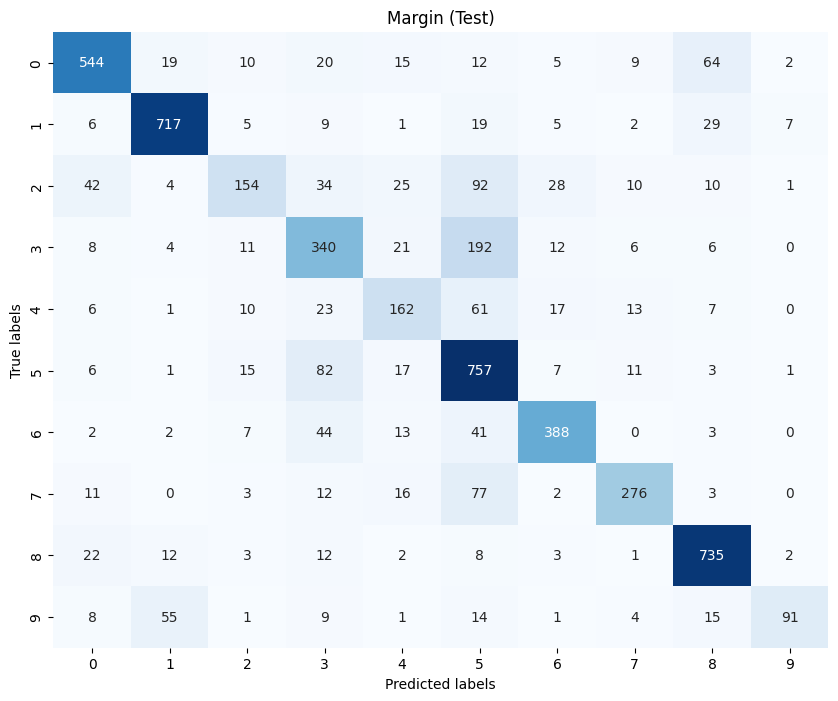

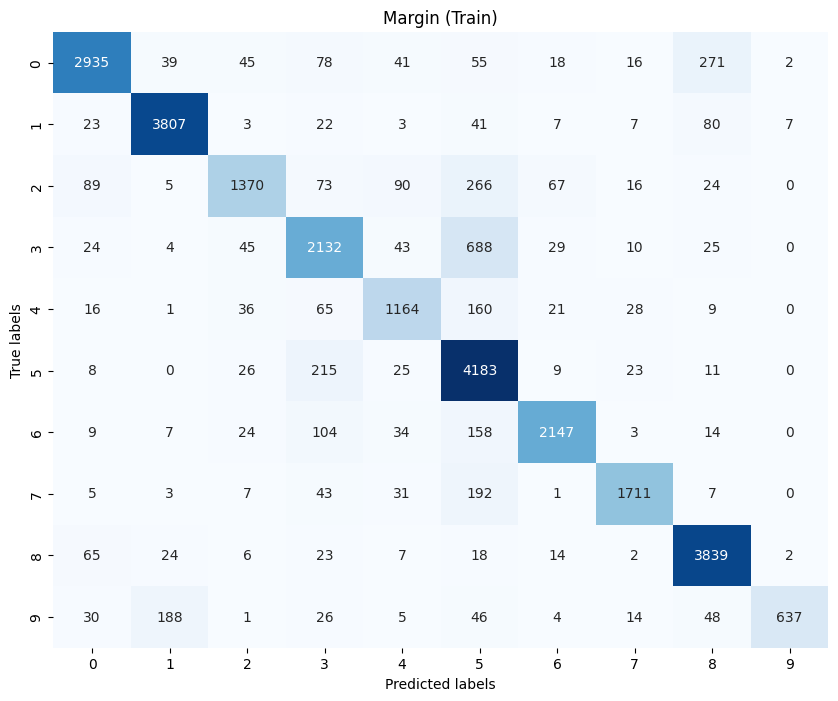

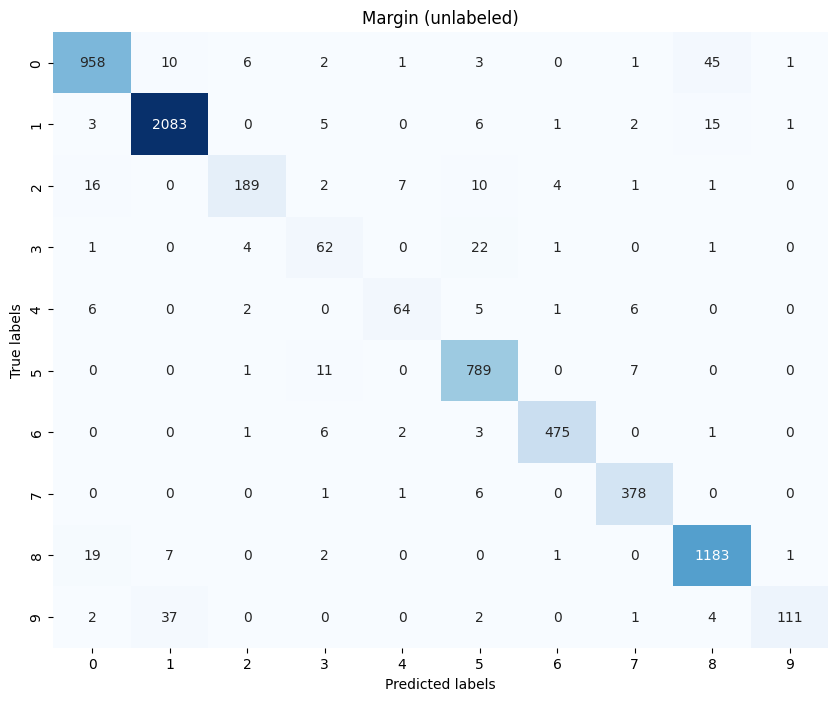

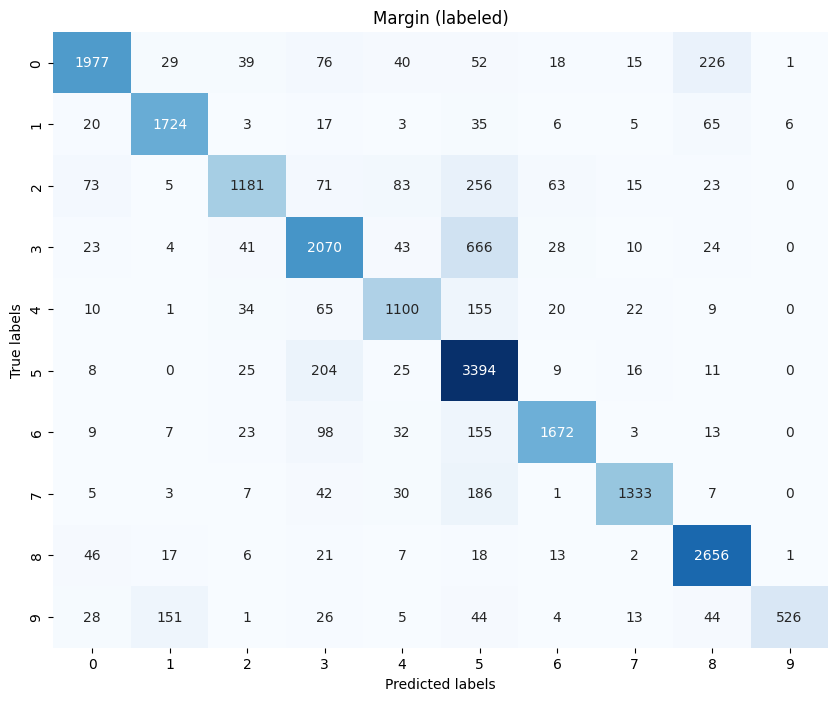

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Margin (labeled)')
plt.show()




In [27]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.83      0.78      0.80       700
           1       0.88      0.90      0.89       800
           2       0.70      0.39      0.50       400
           3       0.58      0.57      0.57       600
           4       0.59      0.54      0.57       300
           5       0.59      0.84      0.70       900
           6       0.83      0.78      0.80       500
           7       0.83      0.69      0.75       400
           8       0.84      0.92      0.88       800
           9       0.88      0.46      0.60       199

    accuracy                           0.74      5599
   macro avg       0.76      0.68      0.71      5599
weighted avg       0.75      0.74      0.74      5599

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      3500
           1       0.93      0.95      0.94      4000
           2       0.88      0.69      0.77      2000
           3       0.77 

# Entropy Sampling

In [30]:
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)



# Define the custom predict_proba function
def predict_proba_custom(model, X):
    raw_predictions = model.predict(X)
    class_probabilities = np.exp(raw_predictions) / np.sum(np.exp(raw_predictions), axis=1, keepdims=True)
    return class_probabilities

# Assign the custom predict_proba function to the estimator
model.predict_proba = lambda X: predict_proba_custom(model, X)


learner = ActiveLearner(
    estimator=model,
    X_training=x_labeled,
    y_training=y_labeled,
    query_strategy=entropy_sampling
)

n_queries = 10

n_samples_per_iteration = 2000


# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)

    queried_labels = y_unlabeled[query_idx]

    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)



    learner.teach(query_sample, queried_labels)

    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')


    # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')


     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')



    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')

    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")

832/832 [==============================] - 2s 3ms/step
X_labeled  (3399, 32, 32, 3)
y_labeled  (3399, 10)
learner x_train  (1399, 32, 32, 3)
learner y_train  (1399, 10)
875/875 [==============================] - 3s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  1/107 [..............................] - ETA: 2s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107/107 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175/175 [==============================] - 0s 3ms/step
Iteration 1 - Train Accuracy: 0.1544, Train Precision: 0.2959, Train Recall: 0.1606, Train F1: 0.1069
Iteration 1 - Test Accuracy: 0.1547, Test Precision: 0.2904, Test Recall: 0.1596, Test F1: 0.1072
Iteration 1 - Labeled Accuracy: 0.1945, Labeled Precision: 0.2984, Labeled Recall: 0.1873, Labeled F1: 0.1398
Iteration 1 - unlabeled Accuracy: 0.1489, unlabeled Precision: 0.2916, unlabeled Recall: 0.1558, unlabeled F1: 0.0999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


769/769 [==============================] - 2s 3ms/step
X_labeled  (5399, 32, 32, 3)
y_labeled  (5399, 10)
learner x_train  (3399, 32, 32, 3)
learner y_train  (3399, 10)
175/175 [==============================] - 0s 3ms/step
Iteration 2 - Train Accuracy: 0.3950, Train Precision: 0.4817, Train Recall: 0.3410, Train F1: 0.3250
Iteration 2 - Test Accuracy: 0.3944, Test Precision: 0.4850, Test Recall: 0.3430, Test F1: 0.3273
Iteration 2 - Labeled Accuracy: 0.4547, Labeled Precision: 0.5249, Labeled Recall: 0.3832, Labeled F1: 0.3717
Iteration 2 - unlabeled Accuracy: 0.3808, unlabeled Precision: 0.4698, unlabeled Recall: 0.3313, unlabeled F1: 0.3135
707/707 [==============================] - 3s 4ms/step
X_labeled  (7399, 32, 32, 3)
y_labeled  (7399, 10)
learner x_train  (5399, 32, 32, 3)
learner y_train  (5399, 10)
175/175 [==============================] - 1s 3ms/step
Iteration 3 - Train Accuracy: 0.5707, Train Precision: 0.5610, Train Recall: 0.5056, Train F1: 0.4955
Iteration 3 - Test Acc

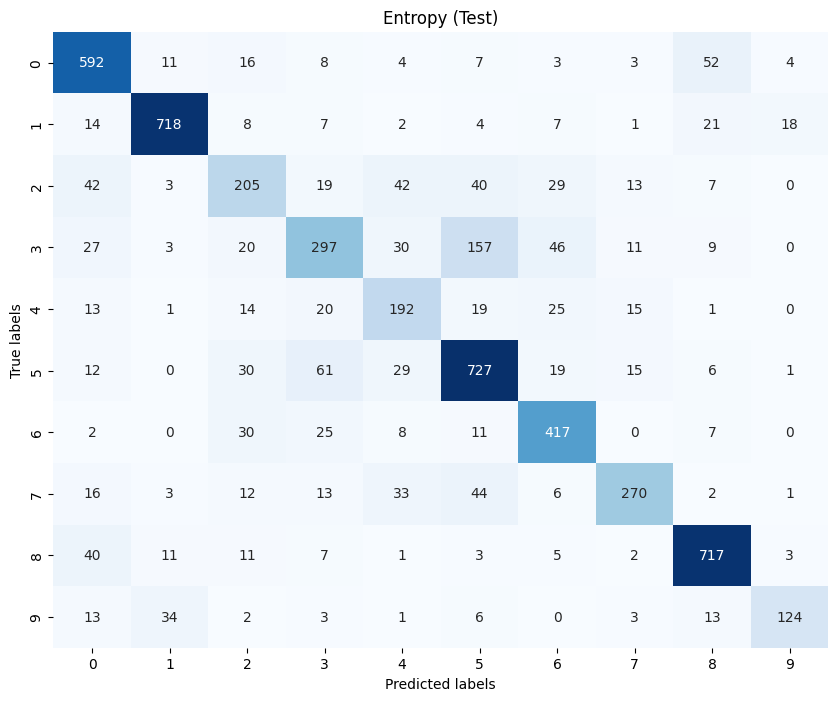

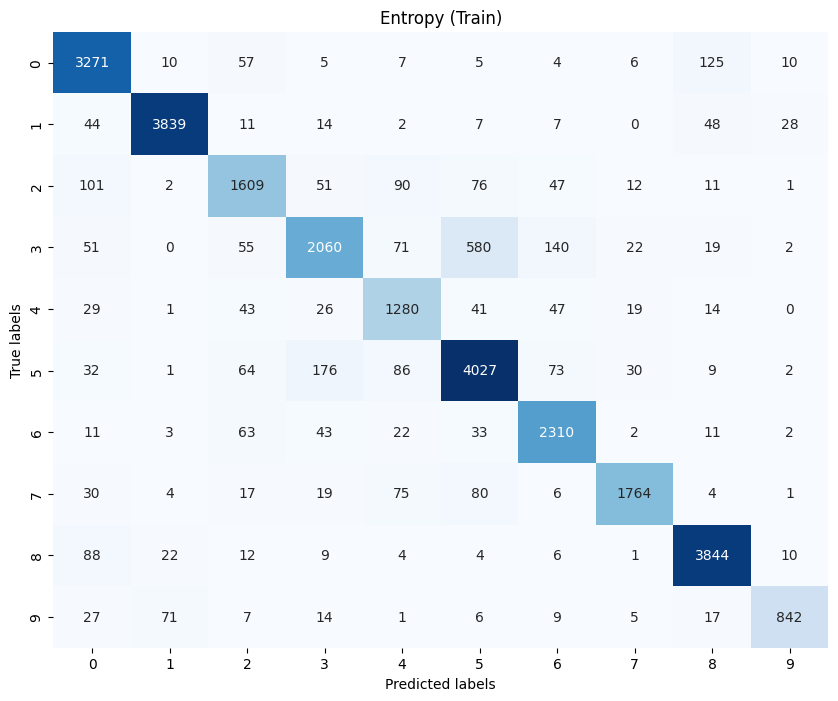

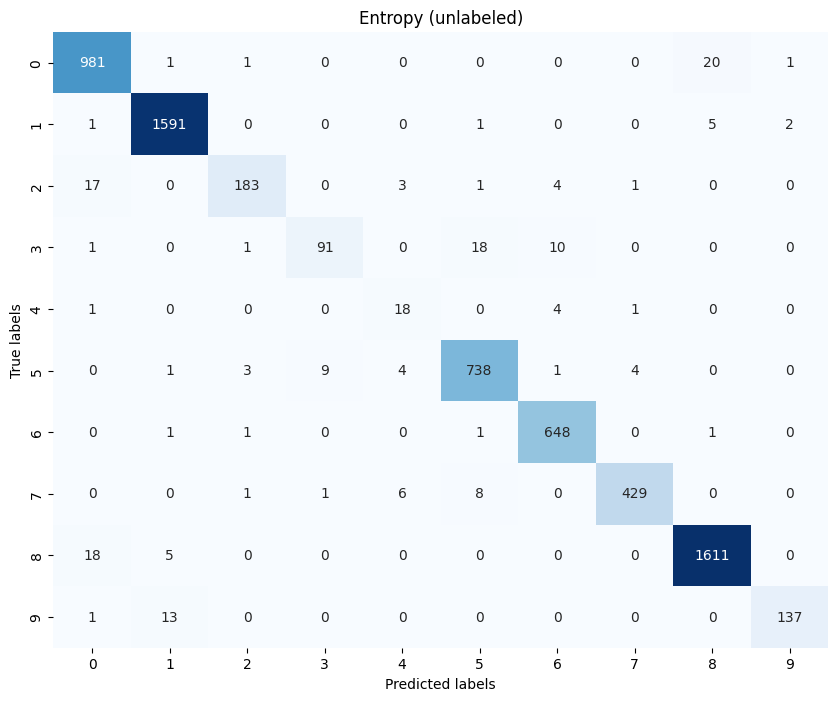

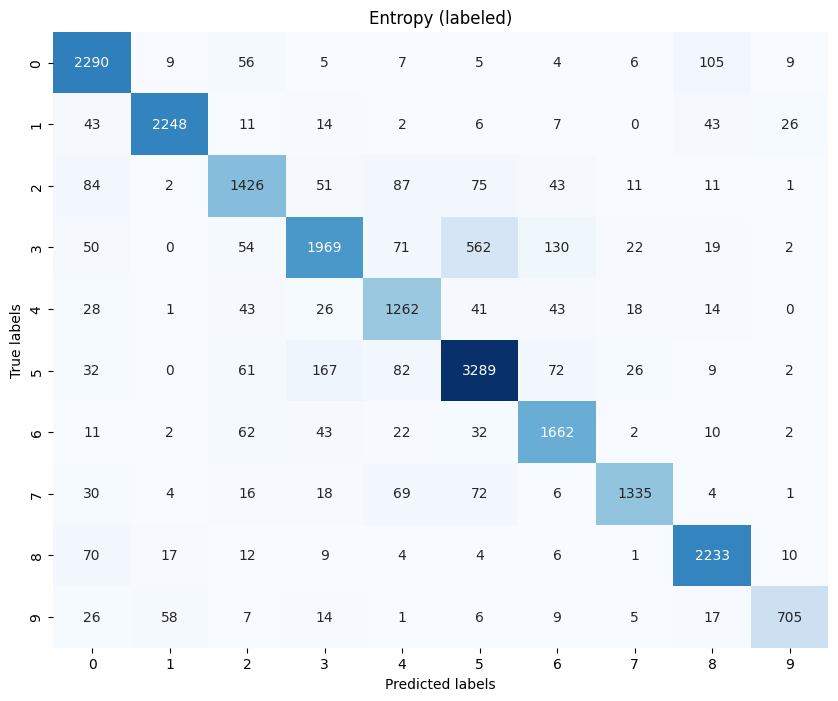

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Entropy (labeled)')
plt.show()




In [32]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.77      0.85      0.80       700
           1       0.92      0.90      0.91       800
           2       0.59      0.51      0.55       400
           3       0.65      0.49      0.56       600
           4       0.56      0.64      0.60       300
           5       0.71      0.81      0.76       900
           6       0.75      0.83      0.79       500
           7       0.81      0.68      0.74       400
           8       0.86      0.90      0.88       800
           9       0.82      0.62      0.71       199

    accuracy                           0.76      5599
   macro avg       0.74      0.72      0.73      5599
weighted avg       0.76      0.76      0.76      5599

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3500
           1       0.97      0.96      0.97      4000
           2       0.83      0.80      0.82      2000
           3       0.85 

# Density Based Sampling

In [12]:
from sklearn.neighbors import KernelDensity
from modAL.models import ActiveLearner
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Split the initial labeled dataset into labeled and unlabeled subsets
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(
    x_train, y_train, test_size=0.95, random_state=42)


from sklearn.decomposition import PCA

def density_based_sampling(classifier, X_pool, n_instances):
    pca = PCA(n_components=2)
    X_pool_reduced = pca.fit_transform(X_pool.reshape(len(X_pool), -1))

    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(X_pool_reduced)

    density_scores = kde.score_samples(X_pool_reduced)

    query_idx = np.argsort(density_scores)[-n_instances:]

    return query_idx, X_pool[query_idx]


learner = ActiveLearner(
    estimator=model,
    X_training=x_labeled,
    y_training=y_labeled,
    query_strategy=density_based_sampling
)

n_queries = 10
n_samples_per_iteration = 2000

# Training loop
for i in range(n_queries):

    query_idx, query_sample = learner.query(x_unlabeled, n_instances=n_samples_per_iteration)

    queried_labels = y_unlabeled[query_idx]

    # Label the queried samples and update the labeled dataset
    x_labeled = np.concatenate([x_labeled, query_sample])
    y_labeled = np.concatenate([y_labeled, queried_labels])
    x_unlabeled = np.delete(x_unlabeled, query_idx, axis=0)
    y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)

    print("X_labeled " , x_labeled.shape)
    print("y_labeled " , y_labeled.shape)
    print("learner x_train " , learner.X_training.shape)
    print("learner y_train " , learner.y_training.shape)



    learner.teach(query_sample, queried_labels)

    # Evaluate the model's performance on the training set
    train_pred = learner.predict(x_train)
    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
    train_precision = precision_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_recall = recall_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')
    train_f1 = f1_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1), average='macro')


     # Evaluate the model's performance on the unlabeled set
    unlabeled_pred = learner.predict(x_unlabeled)
    unlabeled_accuracy = accuracy_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
    unlabeled_precision = precision_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_recall = recall_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')
    unlabeled_f1 = f1_score(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1), average='macro')


     # Evaluate the model's performance on the labeled set
    labeled_pred = learner.predict(x_labeled)
    labeled_accuracy = accuracy_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))
    labeled_precision = precision_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_recall = recall_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')
    labeled_f1 = f1_score(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1), average='macro')



    # Evaluate the model's performance on the test set
    test_pred = learner.predict(x_test)
    test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
    test_precision = precision_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_recall = recall_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')
    test_f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), average='macro')

    print(f"Iteration {i+1} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Iteration {i+1} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
    print(f"Iteration {i+1} - Labeled Accuracy: {labeled_accuracy:.4f}, Labeled Precision: {labeled_precision:.4f}, Labeled Recall: {labeled_recall:.4f}, Labeled F1: {labeled_f1:.4f}")
    print(f"Iteration {i+1} - unlabeled Accuracy: {unlabeled_accuracy:.4f}, unlabeled Precision: {unlabeled_precision:.4f}, unlabeled Recall: {unlabeled_recall:.4f}, unlabeled F1: {unlabeled_f1:.4f}")


44/44 [==============================] - 29s 483ms/step - loss: 2.6386 - accuracy: 0.2788
X_labeled  (3399, 32, 32, 3)
y_labeled  (3399, 10)
learner x_train  (1399, 32, 32, 3)
learner y_train  (1399, 10)
875/875 [==============================] - 63s 71ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


769/769 [==============================] - 54s 70ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


107/107 [==============================] - 8s 77ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175/175 [==============================] - 12s 70ms/step
Iteration 1 - Train Accuracy: 0.1641, Train Precision: 0.2259, Train Recall: 0.1600, Train F1: 0.1043
Iteration 1 - Test Accuracy: 0.1586, Test Precision: 0.2197, Test Recall: 0.1547, Test F1: 0.0975
Iteration 1 - Labeled Accuracy: 0.1753, Labeled Precision: 0.3358, Labeled Recall: 0.1618, Labeled F1: 0.1039
Iteration 1 - unlabeled Accuracy: 0.1626, unlabeled Precision: 0.2143, unlabeled Recall: 0.1596, unlabeled F1: 0.1042


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


X_labeled  (5399, 32, 32, 3)
y_labeled  (5399, 10)
learner x_train  (3399, 32, 32, 3)
learner y_train  (3399, 10)
175/175 [==============================] - 12s 71ms/step
Iteration 2 - Train Accuracy: 0.3654, Train Precision: 0.4995, Train Recall: 0.3081, Train F1: 0.2817
Iteration 2 - Test Accuracy: 0.3561, Test Precision: 0.4882, Test Recall: 0.2993, Test F1: 0.2737
Iteration 2 - Labeled Accuracy: 0.3966, Labeled Precision: 0.5145, Labeled Recall: 0.3305, Labeled F1: 0.3048
Iteration 2 - unlabeled Accuracy: 0.3580, unlabeled Precision: 0.4967, unlabeled Recall: 0.3023, unlabeled F1: 0.2762
X_labeled  (7399, 32, 32, 3)
y_labeled  (7399, 10)
learner x_train  (5399, 32, 32, 3)
learner y_train  (5399, 10)
175/175 [==============================] - 12s 70ms/step
Iteration 3 - Train Accuracy: 0.5471, Train Precision: 0.5415, Train Recall: 0.5167, Train F1: 0.5100
Iteration 3 - Test Accuracy: 0.5235, Test Precision: 0.5130, Test Recall: 0.4920, Test F1: 0.4849
Iteration 3 - Labeled Accuracy

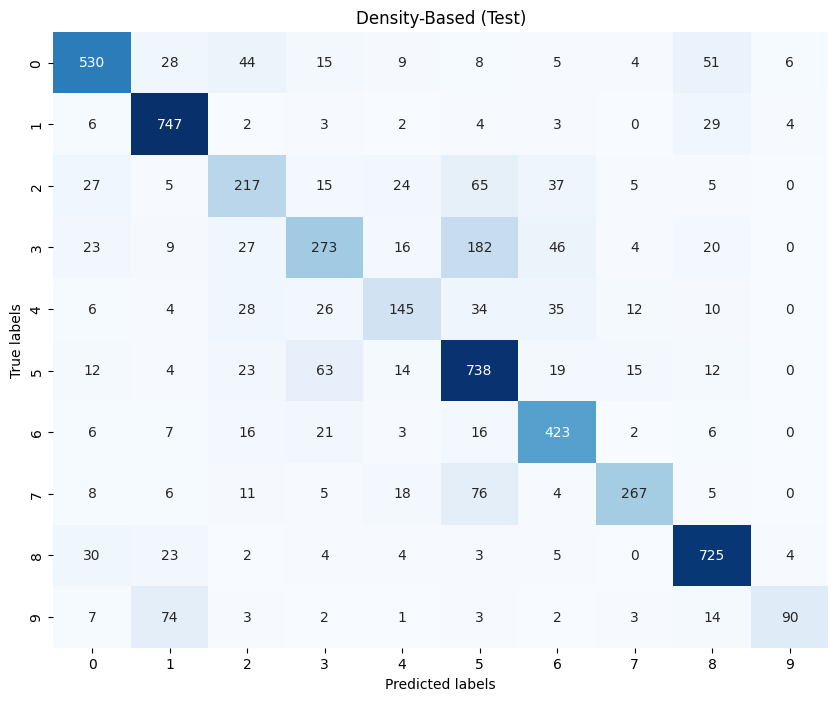

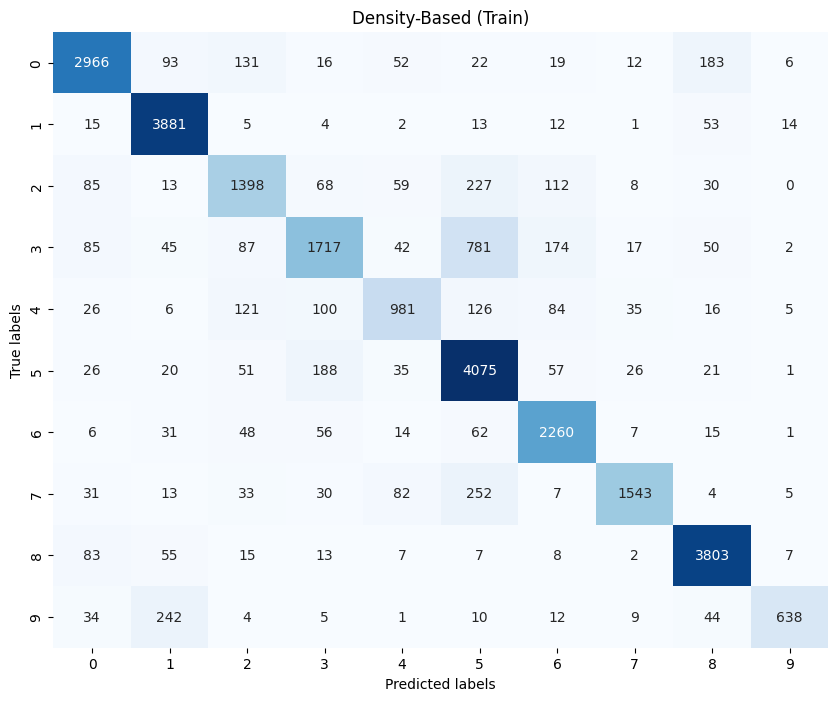

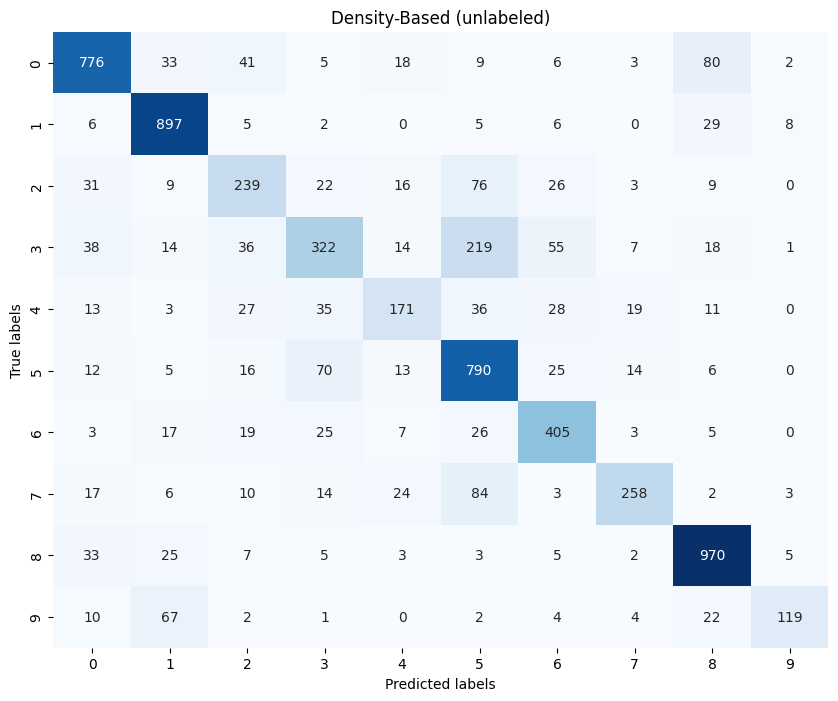

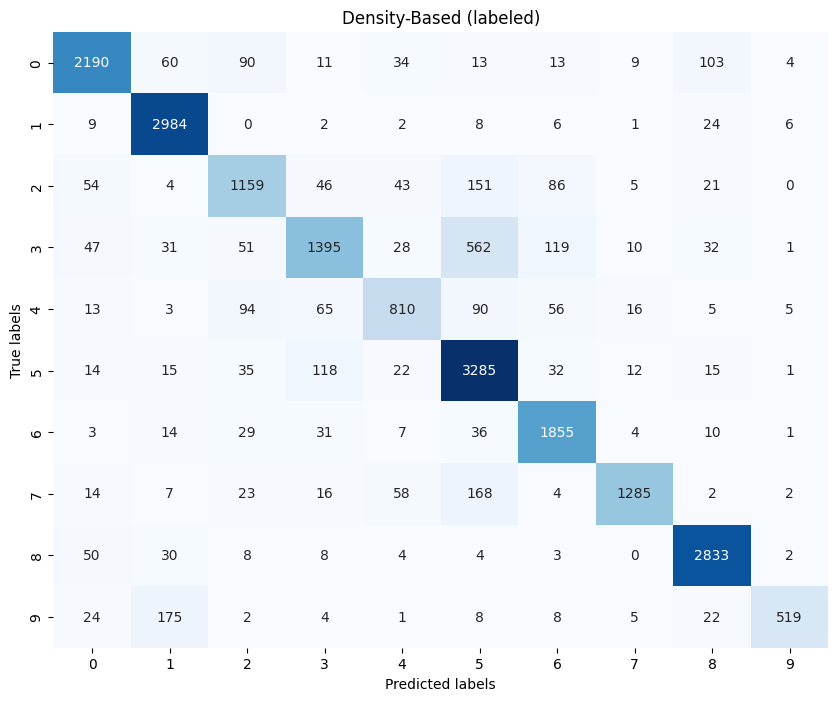

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (Test)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (Train)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (unlabeled)')
plt.show()


conf_matrix = confusion_matrix(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Density-Based (labeled)')
plt.show()




In [14]:
from sklearn.metrics import classification_report

report1 = classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
report2 = classification_report(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))
report3 = classification_report(np.argmax(y_unlabeled, axis=1), np.argmax(unlabeled_pred, axis=1))
report4 = classification_report(np.argmax(y_labeled, axis=1), np.argmax(labeled_pred, axis=1))

print(report1)
print(report2)
print(report3)
print(report4)


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       700
           1       0.82      0.93      0.88       800
           2       0.58      0.54      0.56       400
           3       0.64      0.46      0.53       600
           4       0.61      0.48      0.54       300
           5       0.65      0.82      0.73       900
           6       0.73      0.85      0.78       500
           7       0.86      0.67      0.75       400
           8       0.83      0.91      0.86       800
           9       0.87      0.45      0.59       199

    accuracy                           0.74      5599
   macro avg       0.74      0.69      0.70      5599
weighted avg       0.74      0.74      0.73      5599

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3500
           1       0.88      0.97      0.92      4000
           2       0.74      0.70      0.72      2000
           3       0.78 